In [195]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

f = open("transaction-data-adhoc-analysis.json", "r")
data = json.load(f)
    
""" 
headers: 'address', 'birthdate', 'mail', 'name', 
    'sex', 'username', 'transaction_items', 'transaction_value', 
    'transaction_date'
"""
df_data = pd.DataFrame(data)

In [196]:
def order_count(orders, column):
    order = [x.split(",") for x in orders.split(";")]
    order = [item for sublist in order for item in sublist]
    order_number = order[order.index(column) + 1]
    order_number = int(order_number[2:len(order_number)-1])
    return order_number

# creating an order tally
order_list = []
for orders in df_data['transaction_items']:
    for order in orders.split(";"):
        category, order_name, order_number = order.split(",")
        if order_name not in order_list:
            order_list.append(order_name)
    
for orders in order_list:
    df_data[orders] = df_data['transaction_items'].apply(lambda row: order_count(row, orders) if orders in row else 0)

df_data.loc[:,['username', 'transaction_items', 'Beef Chicharon', 'Nutrional Milk', 'Orange Beans', 'Gummy Vitamins',
       'Yummy Vegetables', 'Gummy Worms', 'Kimchi and Seaweed']].head(5)

,username,transaction_items,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
0,veronicawells,"Exotic Extras,Beef Chicharon,(x4)",4,0,0,0,0,0,0
1,cgilbert,"Exotic Extras,Beef Chicharon,(x3);HealthyKid 3...",3,4,1,0,0,0,0
2,cgilbert,"HealthyKid 3+,Gummy Vitamins,(x3);HealthyKid 3...",0,0,0,3,2,0,0
3,cgilbert,"HealthyKid 3+,Yummy Vegetables,(x1)",0,0,0,0,1,0,0
4,qhernandez,"Candy City,Orange Beans,(x3);Candy City,Gummy ...",0,0,3,1,0,4,0


In [197]:
# getting the month from transaction_date
def find_month(date):
    months = ["", "January", "February", "March", 
              "April", "May", "June", "July", "August",
             "September", "October", "November", "December"]
    
    return months[int(date[5:7])]

df_data['month'] = df_data['transaction_date'].apply(find_month)

In [198]:
# pivot table with months and order count
df_pivotcount_unarranged = pd.pivot_table(data = df_data, index = 'month', values = order_list, aggfunc = 'sum')
df_pivotcount = df_pivotcount_unarranged.reindex(['January', 'February', 'March', 'April', 'May', 'June'])
df_pivotcount = df_pivotcount.reindex(columns = order_list)

df_pivotcount

,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
month,,,,,,,
January,9665,9727,9774,9681,9959,9559,9676
February,10001,9691,10037,9980,10256,9996,9949
March,9816,9876,9611,10145,9896,9986,9967
April,9890,9786,9914,9842,9861,10043,9921
May,10028,9881,9964,9948,9735,9801,9773
June,9902,9767,10106,9980,9722,9934,10104


<AxesSubplot:xlabel='month'>

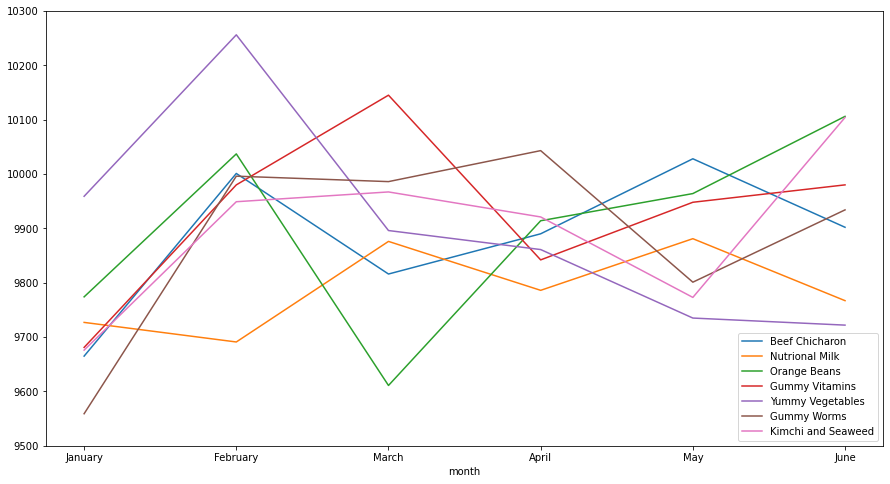

In [199]:
df_pivotcount.plot(kind="line", figsize = (15, 8), ylim = [9500, 10300])

In [202]:
# finding the price per item
def item_number(N):
    string = "".join([str(x) for x in list(N)])
    return len(string.replace("0", ""))

df_datavalue = df_data[["username", "month", "transaction_items", "transaction_value"] + order_list].copy()
df_datavalue["item_number"] = df_datavalue.loc[:, 'Beef Chicharon':'Kimchi and Seaweed'].apply(item_number, axis = 1)

price_list = {}
for order in order_list:
    temp = df_datavalue[(df_datavalue["item_number"] == 1) & (df_datavalue[order] != 0)].head(1)
    price_list[order] = [float(temp["transaction_value"] / temp[order])] 
    
df_price_list = pd.DataFrame(price_list)
df_price_list

,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
0,1299.0,1990.0,199.0,1500.0,500.0,150.0,799.0


In [203]:
# finding generated revenue per item per month
df_salerevenue = df_pivotcount.multiply(np.array(df_price_list), axis = 'columns')
df_salerevenue

,Beef Chicharon,Nutrional Milk,Orange Beans,Gummy Vitamins,Yummy Vegetables,Gummy Worms,Kimchi and Seaweed
month,,,,,,,
January,12554835.0,19356730.0,1945026.0,14521500.0,4979500.0,1433850.0,7731124.0
February,12991299.0,19285090.0,1997363.0,14970000.0,5128000.0,1499400.0,7949251.0
March,12750984.0,19653240.0,1912589.0,15217500.0,4948000.0,1497900.0,7963633.0
April,12847110.0,19474140.0,1972886.0,14763000.0,4930500.0,1506450.0,7926879.0
May,13026372.0,19663190.0,1982836.0,14922000.0,4867500.0,1470150.0,7808627.0
June,12862698.0,19436330.0,2011094.0,14970000.0,4861000.0,1490100.0,8073096.0


In [205]:
def convert_string(N):
    return "".join([str(i) for i in list(N)])

def check_status(status):
    if status[-1] == '0':
        return "Inactive"
    status = status.lstrip('0')
    if set(status) == {'1'}:
        return "Engaged"
    else:
        return "Repeater"
    
df_customercount_unarranged = pd.pivot_table(data = df_datavalue, index = 'username', 
                                  columns = 'month', values = 'item_number', 
                                  aggfunc = len, fill_value = 0)
df_customercount = df_customercount_unarranged[['January', 'February', 'March', 'April', 'May', 'June']]

for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    df_customercount[month] = df_customercount[month].apply(lambda x: 0 if x == 0 else 1)

for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    df_customercount["transposed_status"] = df_customercount.loc[:,'January': month].apply(convert_string, axis = 1)
    df_customercount[month + " Status"] = df_customercount["transposed_status"].apply(check_status)

df_customercategory_unarranged = pd.DataFrame()
for month in ['January', 'February', 'March', 'April', 'May', 'June']:
    df = df_customercount[month + " Status"].value_counts()
    if 'Repeater' not in df:
        df['Repeater'] = 0
    df_customercategory_unarranged[month] = df
    
df_customercategory_unarranged.reindex(['Repeater', 'Inactive','Engaged'], fill_value = 1)

,January,February,March,April,May,June
Repeater,0,0,1079,2100,2997,3754
Inactive,1922,1875,1847,1937,1918,1840
Engaged,6583,6630,5579,4468,3590,2911


In [124]:
f.close()